In [1]:
#把csv中的数据把lebel和txt分开 写入txt  tetx这个句子词用于glove或者word2vec训练使用的 
import pandas as pd
def save_textorlabel_txt(in_filename,out_text_filename,out_label_filename):
    df=pd.read_csv(in_filename)
    with open(in_filename, 'r') as f: #计算长度
        hang_count=len(f.readlines())
        print(hang_count)
    for i in range(1,hang_count-1,1): #以防数据多少回出现问题啥的 
        row=df.values[i]
        row=row[0].split()  #把这些数据变成一个列表
        label=row[0]        # 取出来列表的第一个值是标签 
        file_0=open(out_label_filename,'a')
        file_0.write(str(label))
        file_0.write("\n")
        file_0.close()
        
        hang_txt=row[1:]    # 取出来剩余的数据是这一行的数据
        file = open(out_text_filename,'a')
        for i in range(len(hang_txt)):
             file.write(str(hang_txt[i])+" ")
        file.write("\n")
        file.close()
    print("完成了")
save_textorlabel_txt('train_set.csv','text.txt','label.txt')

1730


把glove生成的词向量模型转化成word2vec的类型 然后用gensim中的函数来读取这个词向量  这个模型中
一共有3216个词向量 每个词向量是300维 在训练的时候 出现次数小于5次的单词给忽略掉了 

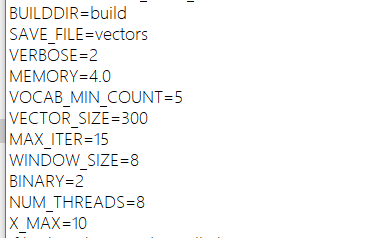

下面是导入这个词向量模型 进行一些读取测试

In [1]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
# glove2word2vec("text_train_glove_vectors.txt", "text_train_vectors_wd2.txt") #
new_model = KeyedVectors.load_word2vec_format('text_train_vectors_wd2.txt', binary=False)
vectors = new_model.wv.vectors

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


先把csv中一个句子拿出来  然后把每个单词去词训练库里面找对应的向量规定对于每个句子矩阵都构建一个2000,300的矩阵。

In [2]:
import pandas as pd
import numpy as np 
df=pd.read_csv("train_set.csv")
# with open("train_set.csv", 'r') as f: #计算长度
#     hang_count=len(f.readlines())
def hang_vectoes_label(index): # 要读取csv文本第几行的文章数据 会返回一个 列表里面是文章的词向量矩阵和标签值
    row=df.values[index] #读取数据的第几行
    row=row[0].split()   #这些数据变成一个列表
    label=row[0]
    hang_txt=row[1:]
    hang_labeltxt_juzhen=[]
    meihang_wenben_juzhen=np.zeros((2000,300))#，每一个文本定义一个空的全0的2000,300的矩阵 
    t=0
    for a in hang_txt:
        try:
            vec = new_model[a]  #从词库里面取出这些词对应的向量 
        except KeyError:        #当在词向量模型中没有这个单词的向量的时候可以设置错误跳过 然后把这个单词的向量设置为全0
            vec=np.zeros((1,300))
        meihang_wenben_juzhen[int(t)]=vec
        if t ==1999:
            break
        t=t+1
#     print(meihang_wenben_juzhen.shape)
    hang_labeltxt_juzhen.append(label)
    hang_labeltxt_juzhen.append(meihang_wenben_juzhen)
    return hang_labeltxt_juzhen
# a=hang_vectoes_label(0)  #返回一个列表 第一个是行文本的分类的label 第二个是行文本 2000*300 的词向量矩阵 
# # 这个原始数据有1730条文本 数据 

手动对数据分batch 并且把数据加载到dataloader

In [3]:
import torch
import torch.utils.data as data
def dataloader_batch(start,end,batch,shuffle):# 把多少行的数据加入到这个data.TensorDataset中 然后在对这个中的这些行数据分batch训练
            #     开始     终止 batch大小  是否打乱 True False 
    x=[]
    y=[]
    for i in range(int(start),int(end),1):
        a=hang_vectoes_label(i)
        x_1=a[1]
        y_1=int(a[0])
        x.append(x_1)
        y.append(y_1)
    x=torch.Tensor(x)
    y=torch.Tensor(y)
    torch_dataset = data.TensorDataset(x, y) #要求这两部分 第一个维度是相同的 
    loader = data.DataLoader(
        dataset=torch_dataset,
        batch_size=batch,             # 每批提取的数量
        shuffle=shuffle,             # 要不要打乱数据（打乱比较好）
        num_workers=0)            # 多少线程来读取数据
    return loader 


建立定义，模型。优化器，损失函数 。


In [4]:
import torch
import torch.nn.functional as F
from torch import nn
class BiRNN(nn.Module):
    def __init__(self):
        super(BiRNN, self).__init__()
        
        self.embed_size=300  #样本得输入维度 
        self.num_hiddens=100 # 隐藏层神经元的个数
        self.num_layers=2
        self.encoder = nn.LSTM(input_size=self.embed_size, 
                                hidden_size=self.num_hiddens, 
                                num_layers=self.num_layers,
                                bidirectional=True)
        
        self.decoder = nn.Linear(4*self.num_hiddens, 14)

    def forward(self, x):
        x=x.reshape(2000,32,300)
        #                batch大小
#         print(x.shape)
        x=torch.Tensor(x)
        outputs, _ = self.encoder(x) 
        encoding = torch.cat((outputs[0], outputs[-1]), -1)
        outs = self.decoder(encoding)
        outs = F.sigmoid(outs)
        return outs


In [5]:
model = BiRNN()
# model.aux_logits=False
criterion = torch.nn.CrossEntropyLoss()  # 损失函数的计算 交叉熵损失函数计算
# optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # 优化器
# momentum是优化梯度的方向自动适应学习率

开始训练：
1700多条数据，每次传入dataloader中320条， 然后分6次传入， 每次这360条数据分为10个batch 每个batch有32条数据。 
世代预设3个世代 
当前cpu速度
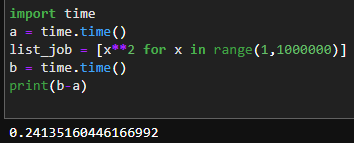

In [ ]:
from torch import tensor
for i in range(6): #全部是6
    print("第"+str(i)+"个320条数据内")
    loader=dataloader_batch(i*320,i*320+320,32,True) 
    # print(loader)
    # torch.Size([320, 2000, 300])
    # torch.Size([320])
    if __name__ == '__main__':
        for epoch in range(3):    # 对整套数据训练3次
             for step, (batch_x, batch_y) in enumerate(loader):  # 每一步loader释放一小批数据用来学习
                    # 训练过程
                    input=batch_x
    #                 print("a",input.shape)
                    target=batch_y
    #                 print("b",target)
                    outputs=model(input)#经过这个模型输出的是 如果批大小是4 就输出四行 每行是14个分类的 二维tensor ,
    #                 print("c",outputs)
                    target =target.long() #转化成长整形张量进行计算 loss
                    loss = criterion(outputs, target)
    #                 print(loss.item())
                    loss.backward()
                    optimizer.step()
                   # 打印数据
                    print("第"+str(i)+"个320条数据内","epoch世代:", epoch, "第"+str(step)+"个batch:","这个batch的损失值" ,loss.item())                    
#保存训练模型
torch.save(model.state_dict(), 'trainModel.pth')
#模型加载：
# model = BiRNN()
# model.load_state_dict(torch.load('trainModel.pth'))
# model.eval()    

第0个320条数据内


/home/admin/.local/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


第0个320条数据内 epoch世代: 0 第0个batch: 这个batch的损失值 2.63988995552063
第0个320条数据内 epoch世代: 0 第1个batch: 这个batch的损失值 2.6415159702301025
第0个320条数据内 epoch世代: 0 第2个batch: 这个batch的损失值 2.6422555446624756
第0个320条数据内 epoch世代: 0 第3个batch: 这个batch的损失值 2.638054370880127
第0个320条数据内 epoch世代: 0 第4个batch: 这个batch的损失值 2.639627456665039
第0个320条数据内 epoch世代: 0 第5个batch: 这个batch的损失值 2.63897705078125
第0个320条数据内 epoch世代: 0 第6个batch: 这个batch的损失值 2.639183759689331
第0个320条数据内 epoch世代: 0 第7个batch: 这个batch的损失值 2.638066053390503
第0个320条数据内 epoch世代: 0 第8个batch: 这个batch的损失值 2.6391093730926514
第0个320条数据内 epoch世代: 0 第9个batch: 这个batch的损失值 2.6350109577178955
第0个320条数据内 epoch世代: 1 第0个batch: 这个batch的损失值 2.6377077102661133
第0个320条数据内 epoch世代: 1 第1个batch: 这个batch的损失值 2.6360113620758057
第0个320条数据内 epoch世代: 1 第2个batch: 这个batch的损失值 2.633929491043091
第0个320条数据内 epoch世代: 1 第3个batch: 这个batch的损失值 2.634321689605713
第0个320条数据内 epoch世代: 1 第4个batch: 这个batch的损失值 2.6320595741271973
第0个320条数据内 epoch世代: 1 第5个batch: 这个batch的损失值 2.633631467819214
第0个

数据集代码在视频下方的链接， 有问题加我头像微信交流。云cpu有点不稳定， 不过这个cpu的计算速度比i7-8700h还快 用我同门的测试来。
估计测试完需要好久好久。 在实验室不方便讲话 
一共是60个batch 一共1700条数据 
分三个世代 
也就是一共测试180个batch
等第二轮看看损失函数降低把，模型很简单 双向lstm加全连接  用的glove预训练词向量 也可以用woed2vec 但是我觉得glove可能更好些  glove训练稍微有点麻烦哈哈，看到了 同样的数据在训练两遍 loss有点降低 但是降低很少  当然了有能力可以训练十个世代  但是我的电脑是不行哈哈   这个云还可以 我的gpu也不行 
到此结束！